In [3]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import torch.optim as optim

In [6]:
full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)

split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

from torch.utils.data import Dataset, DataLoader, Subset

class EmbeddingSequenceDataset(Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingSequenceDataset(train_dataset)
test_ds = EmbeddingSequenceDataset(test_dataset)

def get_loader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

test_loader = get_loader(test_ds, batch_size=32, shuffle=False)
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        out, (h, c) = self.lstm(x.unsqueeze(1))  # Add an extra dimension to the input tensor
        h_last = h[-1]  
        h_last = self.dropout(h_last)
        logits = self.fc(h_last)
        return logits

sample_emb, _ = train_ds[0]
input_dim = sample_emb.shape[0]  # Change to shape[0] to get the correct input dimension
hidden_dim = 128
num_classes = len(np.unique(test_y))  


def train_and_evaluate(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")
    
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    return test_acc, all_preds, all_labels

/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)



使用訓練資料數量: 20 筆
開始訓練...


/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_49079/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


Epoch 1: Train Loss=1.0641, Train Acc=0.6000
Epoch 2: Train Loss=0.8031, Train Acc=0.9000
Epoch 3: Train Loss=0.6666, Train Acc=0.9500
Epoch 4: Train Loss=0.5223, Train Acc=0.9000
Epoch 5: Train Loss=0.4936, Train Acc=0.9500
Epoch 6: Train Loss=0.4015, Train Acc=0.9500
Epoch 7: Train Loss=0.3255, Train Acc=0.9500
Epoch 8: Train Loss=0.3238, Train Acc=0.9500
Epoch 9: Train Loss=0.2508, Train Acc=0.9500
Epoch 10: Train Loss=0.2101, Train Acc=0.9500
Test Loss=0.3525, Test Acc=0.8806
Test Accuracy for sample size 20: 0.8806
Classification Report:
               precision    recall  f1-score   support

contradiction       0.79      0.89      0.84       271
   entailment       0.82      0.94      0.88       564
      neutral       0.94      0.85      0.89      1133

     accuracy                           0.88      1968
    macro avg       0.85      0.89      0.87      1968
 weighted avg       0.89      0.88      0.88      1968

Confusion Matrix:
[[242   2  27]
 [  1 531  32]
 [ 62 111 960]]

/tmp/ipykernel_49079/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


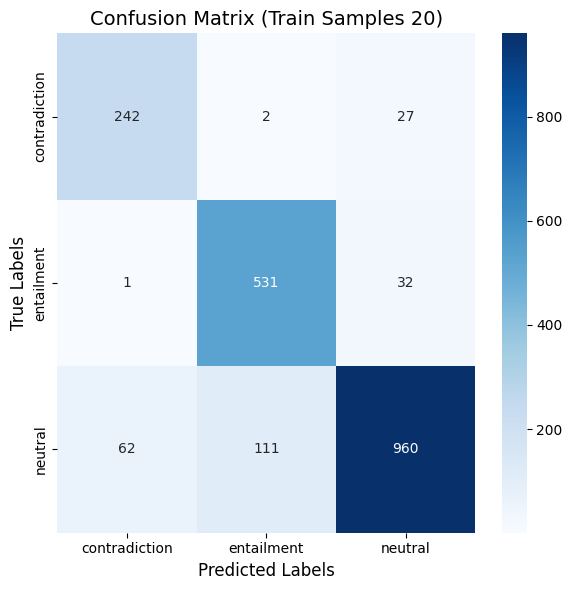

/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_49079/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)



使用訓練資料數量: 50 筆
開始訓練...
Epoch 1: Train Loss=1.0218, Train Acc=0.5200
Epoch 2: Train Loss=0.6953, Train Acc=0.8800
Epoch 3: Train Loss=0.5249, Train Acc=0.8800
Epoch 4: Train Loss=0.4181, Train Acc=0.9200
Epoch 5: Train Loss=0.3480, Train Acc=0.9200
Epoch 6: Train Loss=0.2982, Train Acc=0.9400
Epoch 7: Train Loss=0.2646, Train Acc=0.9400
Epoch 8: Train Loss=0.2385, Train Acc=0.9400
Epoch 9: Train Loss=0.2184, Train Acc=0.9400
Epoch 10: Train Loss=0.1931, Train Acc=0.9400
Test Loss=0.3396, Test Acc=0.8765
Test Accuracy for sample size 50: 0.8765
Classification Report:
               precision    recall  f1-score   support

contradiction       0.81      0.89      0.85       271
   entailment       0.81      0.95      0.87       564
      neutral       0.94      0.84      0.89      1133

     accuracy                           0.88      1968
    macro avg       0.85      0.89      0.87      1968
 weighted avg       0.88      0.88      0.88      1968

Confusion Matrix:
[[240   2  29]
 [  1 

/tmp/ipykernel_49079/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


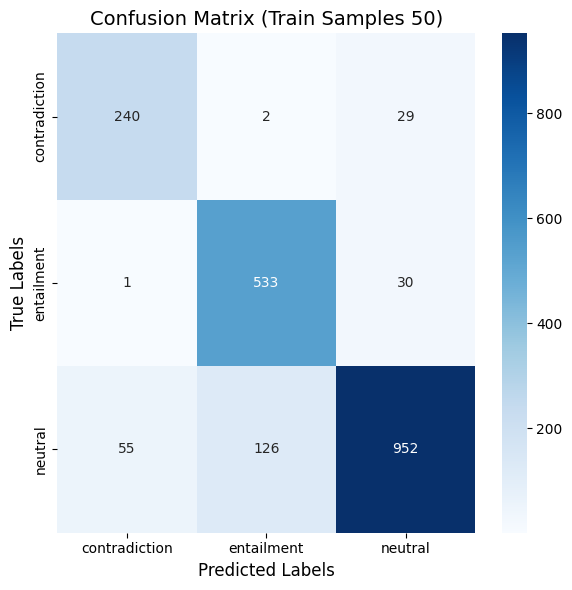

/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_49079/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)



使用訓練資料數量: 70 筆
開始訓練...
Epoch 1: Train Loss=0.9996, Train Acc=0.5714
Epoch 2: Train Loss=0.6353, Train Acc=0.8857
Epoch 3: Train Loss=0.4810, Train Acc=0.8857
Epoch 4: Train Loss=0.3754, Train Acc=0.9286
Epoch 5: Train Loss=0.3176, Train Acc=0.9286
Epoch 6: Train Loss=0.2952, Train Acc=0.9143
Epoch 7: Train Loss=0.2670, Train Acc=0.9286
Epoch 8: Train Loss=0.2361, Train Acc=0.9429
Epoch 9: Train Loss=0.2348, Train Acc=0.9286
Epoch 10: Train Loss=0.2411, Train Acc=0.9429
Test Loss=0.2992, Test Acc=0.8847
Test Accuracy for sample size 70: 0.8847
Classification Report:
               precision    recall  f1-score   support

contradiction       0.80      0.89      0.84       271
   entailment       0.85      0.92      0.88       564
      neutral       0.93      0.87      0.90      1133

     accuracy                           0.88      1968
    macro avg       0.86      0.89      0.87      1968
 weighted avg       0.89      0.88      0.89      1968

Confusion Matrix:
[[241   2  28]
 [  1 

/tmp/ipykernel_49079/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


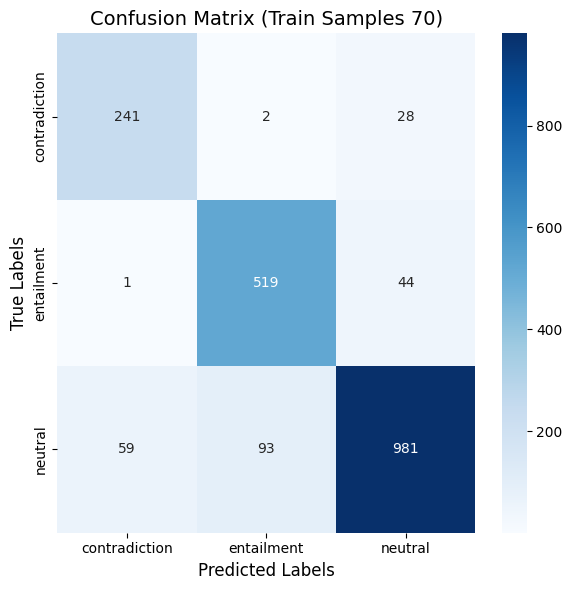

/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_49079/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)



使用訓練資料數量: 100 筆
開始訓練...
Epoch 1: Train Loss=0.9197, Train Acc=0.6700
Epoch 2: Train Loss=0.5284, Train Acc=0.8600
Epoch 3: Train Loss=0.4004, Train Acc=0.9000
Epoch 4: Train Loss=0.3400, Train Acc=0.9000
Epoch 5: Train Loss=0.3081, Train Acc=0.9200
Epoch 6: Train Loss=0.2645, Train Acc=0.9300
Epoch 7: Train Loss=0.2400, Train Acc=0.9200
Epoch 8: Train Loss=0.2408, Train Acc=0.9300
Epoch 9: Train Loss=0.2288, Train Acc=0.9300
Epoch 10: Train Loss=0.2264, Train Acc=0.9300
Test Loss=0.2871, Test Acc=0.8968
Test Accuracy for sample size 100: 0.8968
Classification Report:
               precision    recall  f1-score   support

contradiction       0.89      0.86      0.88       271
   entailment       0.85      0.92      0.88       564
      neutral       0.93      0.89      0.91      1133

     accuracy                           0.90      1968
    macro avg       0.89      0.89      0.89      1968
 weighted avg       0.90      0.90      0.90      1968

Confusion Matrix:
[[ 234    2   35]
 

/tmp/ipykernel_49079/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


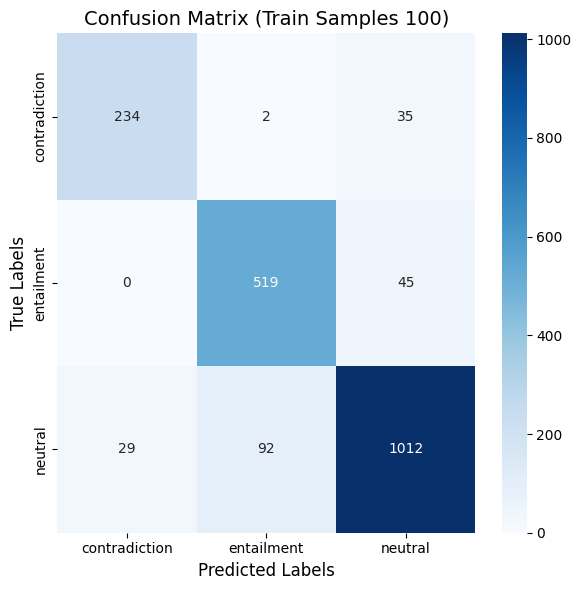

/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_49079/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)



使用訓練資料數量: 300 筆
開始訓練...
Epoch 1: Train Loss=0.5479, Train Acc=0.8600
Epoch 2: Train Loss=0.2968, Train Acc=0.9200
Epoch 3: Train Loss=0.2567, Train Acc=0.9233
Epoch 4: Train Loss=0.2544, Train Acc=0.9133
Epoch 5: Train Loss=0.2236, Train Acc=0.9300
Epoch 6: Train Loss=0.2256, Train Acc=0.9167
Epoch 7: Train Loss=0.2211, Train Acc=0.9333
Epoch 8: Train Loss=0.2222, Train Acc=0.9267
Epoch 9: Train Loss=0.2200, Train Acc=0.9200
Epoch 10: Train Loss=0.1840, Train Acc=0.9367
Test Loss=0.2608, Test Acc=0.9060
Test Accuracy for sample size 300: 0.9060
Classification Report:
               precision    recall  f1-score   support

contradiction       0.89      0.87      0.88       271
   entailment       0.90      0.88      0.89       564
      neutral       0.91      0.93      0.92      1133

     accuracy                           0.91      1968
    macro avg       0.90      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix:
[[ 235    0   36]
 

/tmp/ipykernel_49079/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


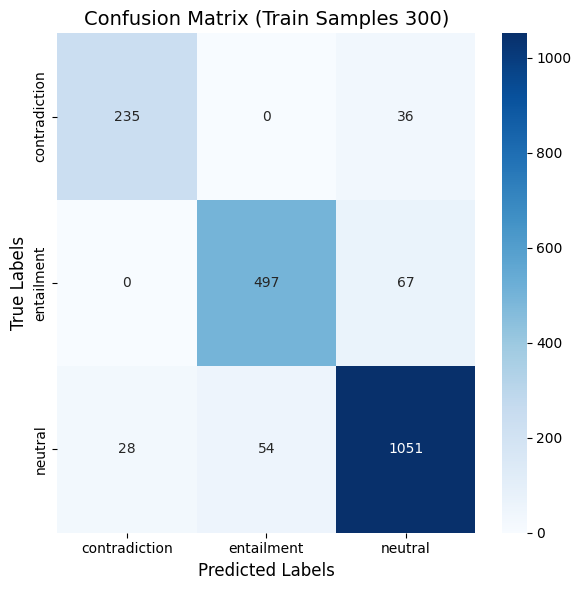


使用訓練資料數量: 1000 筆
開始訓練...


/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_49079/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


Epoch 1: Train Loss=0.3614, Train Acc=0.8880
Epoch 2: Train Loss=0.2388, Train Acc=0.9200
Epoch 3: Train Loss=0.2473, Train Acc=0.9190
Epoch 4: Train Loss=0.2452, Train Acc=0.9160
Epoch 5: Train Loss=0.2293, Train Acc=0.9190
Epoch 6: Train Loss=0.2335, Train Acc=0.9200
Epoch 7: Train Loss=0.2204, Train Acc=0.9280
Epoch 8: Train Loss=0.2190, Train Acc=0.9210
Epoch 9: Train Loss=0.2164, Train Acc=0.9260
Epoch 10: Train Loss=0.2150, Train Acc=0.9280
Test Loss=0.2600, Test Acc=0.9090
Test Accuracy for sample size 1000: 0.9090
Classification Report:
               precision    recall  f1-score   support

contradiction       0.92      0.86      0.89       271
   entailment       0.88      0.91      0.89       564
      neutral       0.92      0.92      0.92      1133

     accuracy                           0.91      1968
    macro avg       0.91      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix:
[[ 232    0   39]
 [   0  512   52]
 [  19 

/tmp/ipykernel_49079/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


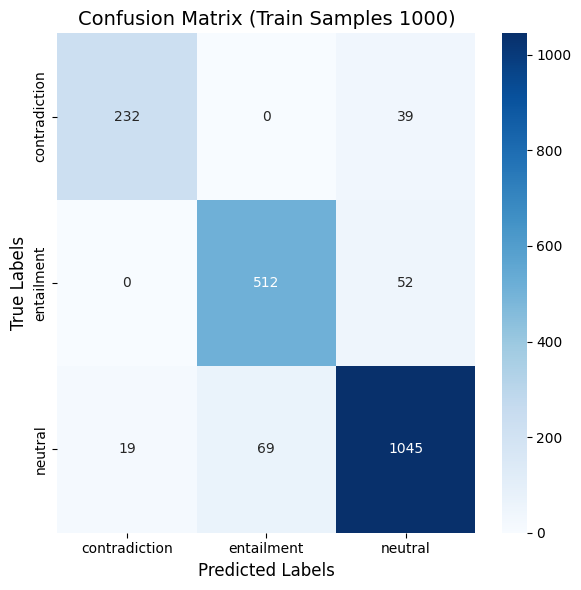


使用訓練資料數量: 7872 筆
開始訓練...


/tmp/ipykernel_49079/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_49079/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


Epoch 1: Train Loss=0.2678, Train Acc=0.9060
Epoch 2: Train Loss=0.2461, Train Acc=0.9083
Epoch 3: Train Loss=0.2385, Train Acc=0.9131
Epoch 4: Train Loss=0.2366, Train Acc=0.9101
Epoch 5: Train Loss=0.2344, Train Acc=0.9102
Epoch 6: Train Loss=0.2381, Train Acc=0.9103
Epoch 7: Train Loss=0.2308, Train Acc=0.9137
Epoch 8: Train Loss=0.2285, Train Acc=0.9148
Epoch 9: Train Loss=0.2246, Train Acc=0.9154
Epoch 10: Train Loss=0.2244, Train Acc=0.9159
Test Loss=0.2322, Test Acc=0.9085
Test Accuracy for sample size 7872: 0.9085
Classification Report:
               precision    recall  f1-score   support

contradiction       0.92      0.85      0.88       271
   entailment       0.91      0.87      0.89       564
      neutral       0.90      0.94      0.92      1133

     accuracy                           0.91      1968
    macro avg       0.91      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix:
[[ 230    0   41]
 [   1  490   73]
 [  19 

/tmp/ipykernel_49079/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


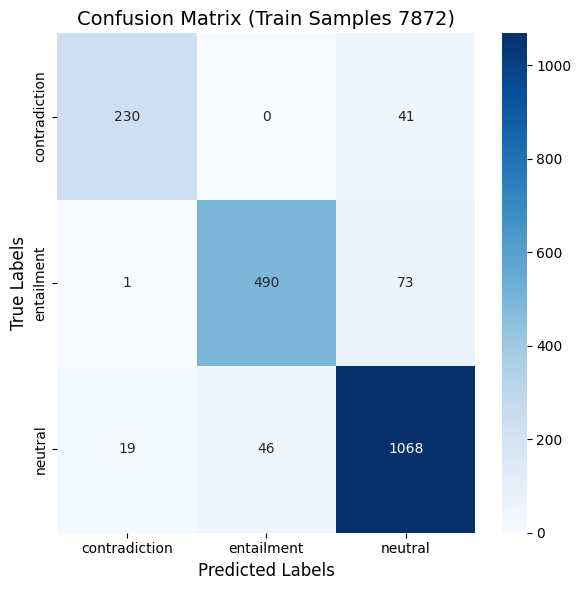

Accuracy Summary:
   train_samples  test_accuracy
0             20       0.880589
1             50       0.876524
2             70       0.884654
3            100       0.896850
4            300       0.905996
5           1000       0.909045
6           7872       0.908537
+----+-----------------+-----------------+
|    |   train_samples |   test_accuracy |
|----+-----------------+-----------------|
|  0 |              20 |        0.880589 |
|  1 |              50 |        0.876524 |
|  2 |              70 |        0.884654 |
|  3 |             100 |        0.89685  |
|  4 |             300 |        0.905996 |
|  5 |            1000 |        0.909045 |
|  6 |            7872 |        0.908537 |
+----+-----------------+-----------------+


In [7]:
from torch.utils.data import Subset
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
num_epochs = 10
learning_rate = 0.001
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

accuracy_summary = []

for size in sample_sizes:
    print(f"\n使用訓練資料數量: {size} 筆")
    train_subset = Subset(train_ds, range(size))
    train_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)
    
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    model.to(device)
    
    print("開始訓練...")
    test_acc, all_preds, all_labels = train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate, device)
    print(f"Test Accuracy for sample size {size}: {test_acc:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["contradiction", "entailment", "neutral"]))
    
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
                xticklabels=["contradiction", "entailment", "neutral"],
                yticklabels=["contradiction", "entailment", "neutral"])
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.title(f"Confusion Matrix (Train Samples {size})", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    accuracy_summary.append({"train_samples": size, "test_accuracy": test_acc})

summary_df = pd.DataFrame(accuracy_summary)
print("Accuracy Summary:")
print(summary_df)
print(tabulate(summary_df, headers='keys', tablefmt='psql'))